Import Libraries

In [2]:
import matplotlib as plt
import numpy as np
import pandas as pd

Import Data

In [23]:
df_dream = pd.read_csv('nct_dream_data.csv')
df_127 = pd.read_csv('nct_127_data.csv')

Visualize dataframe

In [24]:
#Change publishedAt format to datetime (only date)

def to_date(iso_datetime):
    date = iso_datetime.split('T')[0]
    return date

df_dream['publishedAt'] = pd.to_datetime(df_dream['publishedAt'].apply(to_date))
df_127['publishedAt'] = pd.to_datetime(df_127['publishedAt'].apply(to_date))

<AxesSubplot:xlabel='publishedAt', ylabel='viewCount'>

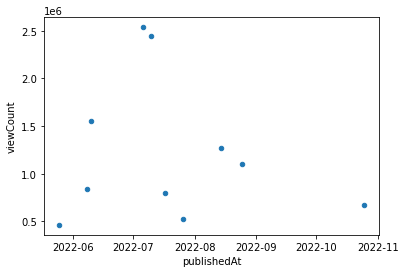

In [29]:
#Remove Shorts
df_dream.drop(df_dream[df_dream['Category']=='Shorts'].index)
df_dream_jakun = df_dream[df_dream['Category']=="Jakun"]
df_dream_jakun.plot(x="publishedAt", y="viewCount", kind="scatter")